# PRELIMINAR
Se cargan las librerías a usar

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error,confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, make_scorer
from scipy.stats import pearsonr

# Preparación de datos


## Seleccionar un conjunto de temporadas para trabajar y justifique su selección
En nuestro caso decidimos seleccionar las ultimas 5 temporadas principalemnte porque en el futbol los últimos partidos tienen mayor relevancia que en otros deportes

Al cargar la base de datos se obtiene lo siguiente

In [6]:
# Importación de los datos
!curl -L -O https://www.football-data.co.uk/mmz4281/2223/E0.csv
df_22_23 = pd.read_csv("E0.csv")
df_22_23['Season'] = '22-23'
!curl -L -O https://www.football-data.co.uk/mmz4281/2122/E0.csv
df_21_22 = pd.read_csv("E0.csv")
df_21_22['Season'] = '21-22'
!curl -L -O https://www.football-data.co.uk/mmz4281/2021/E0.csv
df_20_21 = pd.read_csv("E0.csv")
df_20_21['Season'] = '20-21'
!curl -L -O https://www.football-data.co.uk/mmz4281/1920/E0.csv
df_19_20 = pd.read_csv("E0.csv")
df_19_20['Season'] = '19-20'
!curl -L -O https://www.football-data.co.uk/mmz4281/1819/E0.csv
df_18_19 = pd.read_csv("E0.csv")
df_18_19['Season'] = '18-19'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  152k   10 16119    0     0  14616      0  0:00:10  0:00:01  0:00:09 14613
100  152k  100  152k    0     0   100k      0  0:00:01  0:00:01 --:--:--  100k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  171k  100  171k    0     0   116k      0  0:00:01  0:00:01 --:--:--  116k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   

In [7]:
# A continuacion se une en un solo dataset
df = pd.concat([df_22_23,df_21_22,df_20_21,df_19_20,df_18_19], axis = 0)

### b) Seleccione las variables relevantes para iniciar su exploración y elimine las variables restantes

In [8]:
# Despues de un analisis discrecional no squedamos con estas columnas relevantes
df = df.loc[ : , ['Date',	'Time',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HS',	'AS',	'HST',	'AST',	'HC',	'AC',	'HF',	'AF',	'HY',	'AY',	'HR',	'AR', 'Season']]

# Eliminamos valores nulos
df.dropna(axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape
print(df)

            Date   Time        HomeTeam          AwayTeam  FTHG  FTAG FTR  \
0     05/08/2022  20:00  Crystal Palace           Arsenal     0     2   A   
1     06/08/2022  12:30          Fulham         Liverpool     2     2   D   
2     06/08/2022  15:00     Bournemouth       Aston Villa     2     0   H   
3     06/08/2022  15:00           Leeds            Wolves     2     1   H   
4     06/08/2022  15:00       Newcastle     Nott'm Forest     2     0   H   
...          ...    ...             ...               ...   ...   ...  ..   
1472  26/07/2020  16:00       Leicester        Man United     0     2   A   
1473  26/07/2020  16:00        Man City           Norwich     5     0   H   
1474  26/07/2020  16:00       Newcastle         Liverpool     1     3   A   
1475  26/07/2020  16:00     Southampton  Sheffield United     3     1   H   
1476  26/07/2020  16:00        West Ham       Aston Villa     1     1   D   

      HTHG  HTAG  HS  ...  AST  HC  AC  HF  AF  HY  AY  HR  AR  Season  
0 

### c) Para simplificar su análisis, etiquete los resultados de los partidos en “L” o “V”, y elimine los partidos que resultaron en empate

In [9]:
# Eliminar partidos con empate
df.drop(df[df["FTR"] == "D"].index, axis=0, inplace=True)
df = df.reset_index(drop = True)

In [10]:
# Cambiamos de nombre a Nottingham Forest
df = df.replace("Nott'm Forest","Nottingham Forest", regex=True)

# Feature Engineering

## a) Incremente el número de columnas en la matriz de diseño añadiendo interacciones entre predictores y las transformaciones usuales

In [11]:
# Etiquetar resultados en L o V
df['FTR'] = df['FTR'].apply(lambda x: 'L' if x == 'H'else 'V')
print(df)

            Date   Time        HomeTeam           AwayTeam  FTHG  FTAG FTR  \
0     05/08/2022  20:00  Crystal Palace            Arsenal     0     2   V   
1     06/08/2022  15:00     Bournemouth        Aston Villa     2     0   L   
2     06/08/2022  15:00           Leeds             Wolves     2     1   L   
3     06/08/2022  15:00       Newcastle  Nottingham Forest     2     0   L   
4     06/08/2022  15:00       Tottenham        Southampton     4     1   L   
...          ...    ...             ...                ...   ...   ...  ..   
1132  26/07/2020  16:00         Everton        Bournemouth     1     3   V   
1133  26/07/2020  16:00       Leicester         Man United     0     2   V   
1134  26/07/2020  16:00        Man City            Norwich     5     0   L   
1135  26/07/2020  16:00       Newcastle          Liverpool     1     3   V   
1136  26/07/2020  16:00     Southampton   Sheffield United     3     1   L   

      HTHG  HTAG  HS  ...  AST  HC  AC  HF  AF  HY  AY  HR  AR 

In [12]:
# Variables que se crearan
# HPE = FTHG/HS | APE = FTAG/AS --> proporcion de goles por disparo
# HPS = (HST+HHW)/HS | APS = (AST + AHW)/AS --> proporcion de aproximaciones a gol por disparo
df['HPE'] = df['FTHG']/df['HS']
df['APE'] = df['FTAG']/df['AS']
df['HPS'] = (df['HST'])/df['HS']
df['APS'] = (df['AST'])/df['AS']

#Creando columna en formato fecha
df["Date"] = pd.to_datetime(df["Date"])

#Guardando base original
df_original=df

# A partir de una investigacion que se explicara en la pregunta 2b, creamos
# las siguientes variables:
#HomeWinLastFive
df['Home_Last5_Home_Victories'] = 0

for i, row in df.iterrows():
    
    home_team = row['HomeTeam']
    date = row['Date']
    prev_home_games = df[(df['HomeTeam'] == home_team) & (df['Date'] < date)].tail(5)
    
    num_home_wins = len(prev_home_games[prev_home_games['FTR'] == 'L'])
    
    df.at[i, 'Home_Last5_Home_Victories'] = num_home_wins


#AwayWinLastFive
df['Away_Last5_Away_Victories'] = 0

for i, row in df.iterrows():
    
    away_team = row['AwayTeam']
    date = row['Date']
    prev_away_games = df[(df['AwayTeam'] == away_team) & (df['Date'] < date)].tail(5)
    
    num_away_wins = len(prev_away_games[prev_away_games['FTR'] == 'V'])
    
    df.at[i, 'Away_Last5_Away_Victories'] = num_away_wins



# HomeWinLastFiveConfrontation
df['Last5Confrontation_Home_Victories'] = 0

for i, row in df.iterrows():
    
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    date = row['Date']
    prev_home_games = df[(df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team) & (df['Date'] < date)].tail(5)
    
    num_home_wins = len(prev_home_games[prev_home_games['FTR'] == 'L'])
    
    df.at[i, 'Last5Confrontation_Home_Victories'] = num_home_wins

#AwayWinLastFiveConfrontation
df['Last5Confrontation_Away_Victories'] = 0

for i, row in df.iterrows():
    
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    date = row['Date']
    prev_home_games = df[(df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team) & (df['Date'] < date)].tail(5)
    
    num_away_wins = len(prev_home_games[prev_home_games['FTR'] == 'V'])
    
    df.at[i, 'Last5Confrontation_Away_Victories'] = num_away_wins



In [13]:
# Se crea la funcion para calcular promedios por equipo Local o visitante desde
# el inicio de temporada hasta la fecha que se indica
def NewVariable(dataframe, oldVariable, teamType, nameNewVariable):
  df[nameNewVariable] = 0
  for i, row in df.iterrows():
    season= row['Season']
    team = row[teamType]
    date = row['Date']
    average_prev = df[(df[teamType] == team) & (df['Date'] < date) & (df['Season'] == season)]

    average = average_prev[oldVariable].mean()

    dataframe.at[i, nameNewVariable] = average
  return(dataframe)

df_prueba = NewVariable(df, 'FTHG','HomeTeam','Average_home_goals').head(10)
df_prueba['Average_home_goals']

df=NewVariable(df, 'FTHG','HomeTeam','Average_hometeam_goals')
df=NewVariable(df, 'FTAG','AwayTeam','Average_awayteam_goals')
df=NewVariable(df, 'HPE','HomeTeam','Average_HPE_hometeam')
df=NewVariable(df, 'APE','AwayTeam','Average_APE_awayteam')
df=NewVariable(df, 'HPS','HomeTeam','Average_HPS_hometeam')
df=NewVariable(df, 'APS','AwayTeam','Average_APS_hometeam')


df=NewVariable(df, 'HC','HomeTeam','Average_HC')
df=NewVariable(df, 'AC','AwayTeam','Average_AC')
df=NewVariable(df, 'HF','HomeTeam','Average_HF')
df=NewVariable(df, 'AF','AwayTeam','Average_AF')
df=NewVariable(df, 'HY','HomeTeam','Average_HY')
df=NewVariable(df, 'AY','AwayTeam','Average_AY')
df=NewVariable(df, 'HY','HomeTeam','Average_HR')
df=NewVariable(df, 'AY','AwayTeam','Average_AR')





## b)  Investigue sobre la prediccion de partidos de futbol con herramientas de Machine Learning y explore la construccion de otras variables predictoras (features). Indique las fuentes utilizadas y sus conclusiones.

La ciencia de datos ha ayudado en gran medida a distintas áreas de la industria del fútbol, como en la identificación de estrategias y tácticas, los criterios detrás de los fichajes de los jugadores y la predicción de los resultados de los partidos. En particular, para esto último, se evalúan factores como el rendimiento del equipo en cada juego y el resultado final. Sin embargo, hay también elementos que a primera vista no se reconocen, pero que también aportan a la predicción de los futuros juegos, como el dominio del balón de cada equipo, su cantidad de faltas, entre otros. Ello ha puesto sobre la mesa la necesidad de seguir perfeccionando y creando nuevas herramientas de Machine Learning para que se pueda establecer predicciones cada vez más precisas (Herbinet, 2018). 

Por su lado, Capobianco et al. (2019) reconocen que varias de estas técnicas de predicción usan datasets con un número bastante limitado de variables predictoras, debido a que se centran en factores que se observan una vez terminado el juego, como el número de tarjetas amarillas o rojas recibidas por cada equipo. Por ello, los autores proponen un nuevo método que ayude a predecir el outcome de un partido mientras se está llevando a cabo, lo cual aumenta las probabilidades de que los jugadores mejoren su performance a mitad del juego y cambien el posible resultado. Así, consideran features de cada cierto periodo de tiempo durante el partido, por ejemplo, los segundos de posesión de la pelota de cada equipo en los primeros 15 minutos, entre los 15 y 30 minutos, y así sucesivamente.

Por su parte, Ren y Susnjak (2022) realizan un estudio en torno a tres temporadas de partidos de la Premier League, con el objetivo de perfeccionar estas técnicas de predicción. Hacen uso de un conjunto de novedosas variables predictoras; en particular, consideran que los factores que se observan durante el juego suelen ser más determinísticos y generan resultados más certeros. Así, proponen variables como la capacidad ofensiva y defensiva de cada equipo, la cantidad de veces que anotan un gol jugando en casa o fuera, número de faltas cometidas, etc. 

A su vez, Gomes, Portela y Filipe (2021) presentan una metodología de predicción que toma variables disponibles al público, como el número de goles de cada equipo y  el número de tarjetas amarillas, y las transforma a otras, como el promedio de goles de los equipos, la cantidad de victorias en los últimos 5 partidos para cada equipo, etc. Este proceso, llamado Knowledge Discovery in Database (KDD) permite entender un conjunto de datos complejos que pueden ser de utilidad para la predicción. Se basa en seleccionar la data, procesarla y transformarla, con el fin de encontrar patrones que permitan interpretar adecuadamente las variables y analizar en qué medida logran explicar el modelo.

Por último, Prasetio y Harlili (2016) proponen una regresión logística con la cual también se pueden predecir los resultados de los partidos de fútbol, en donde la variable dependiente será una dicotómica que toma el valor de 1 si el equipo local gana, y 0 si quien gana es el equipo visitante. Concluyen que, al añadir un gran número de variables al modelo, la predicción perdía precisión. Mientras que, si solo se elegían las variables relevantes, los resultados eran más acertados.

En conclusión, la literatura revisada demuestra la importancia de tomar en cuenta distintos factores que puedan predecir de forma precisa los resultados de los partidos de fútbol. Así, algunas de las variables mencionadas han sido incluidas en el modelo Logit binario propuesto para predecir los partidos de la Premier League. En particular, se han seleccionado variables relevantes de una web dispuesta al público y, además, se han generado nuevas a partir de ellas, lo cual permitirá tener predicciones mucho más certeras.
 
 **Referencias**

Capobianco, G., Di Giacomo, U., Mercaldo, F., Nardone, V., & Santone, A. (2019). Can Machine Learning predict soccer match results? Proceedings of the 11th International Conference on Agents and Artificial Intelligence. https://www.scitepress.org/Link.aspx?doi=10.5220/0007307504580465 

Gomes, J., Portela, F., & Filipe, M. (2021). Decision Support System for predicting football game results. FCT - Fação para a Ciência e Tecnologia, Portugal. 

Herbinet, C. (2018). Predicting football results using Machine Learning techniques. Imperial College of Science, Technology and Medicine, Inglaterra. 

Prasetio, D., & Harlili, M. (2016). Predicting football match results with logistic regression. Institut Teknologi Bandung, Indonesia.

Ren, Y., & Susnjak, T. (2022). Predicting football match outcomes with eXplainable Machine Learning and the Kelly Index. School of Mathematical and Computational Sciences, Nueva Zelanda.


# Selección de modelos

## Seleccion de una métrica de desempeño adecuada si su interés en predecir estos partidos de fútbol es apostar.

Seleccionamos la métrica de precisión porque uno busca maximizar la proporción de apuestas ganadas sobre el total de apuestas realizadas. Por lo tanto, se busca no hacer pasar como perdedores a los equipos ganadores, pues finalmente se apuesta por estos últimos. Ello sería minimizar los falsos positivos.

## Seleccion del mejor modelo Logit aplicando Best Subset Selection (BSS). Para comparar entre modelos con diferente numero de variables utilice la metrica seleccionada en lo anterior y validaci´on cruzada con 10-dobleces (10-fold cross validation).

In [14]:
# Se borra los valores nulos
for i in df.columns: 
    if df[i].isnull().sum()>0: print([i, df[i].isnull().sum()])

df.dropna(axis=0,inplace=True)

['Average_home_goals', 80]
['Average_hometeam_goals', 80]
['Average_awayteam_goals', 80]
['Average_HPE_hometeam', 80]
['Average_APE_awayteam', 80]
['Average_HPS_hometeam', 80]
['Average_APS_hometeam', 80]
['Average_HC', 80]
['Average_AC', 80]
['Average_HF', 80]
['Average_AF', 80]
['Average_HY', 80]
['Average_AY', 80]
['Average_HR', 80]
['Average_AR', 80]


In [15]:
# Se crean dummies para categorias relevantes
df = pd.get_dummies(df,columns=['FTR'],prefix=['Result'],drop_first=False)

In [16]:
# Se eliminan algunas variables irrelevantes y nos mantenemos con las creadas y relevantes
df=df.drop(['Result_V'],axis=1)
df=df.loc[:,["Result_L","HomeTeam","AwayTeam","Date","Last5Confrontation_Home_Victories",
             "Last5Confrontation_Away_Victories","Home_Last5_Home_Victories", 
             "Away_Last5_Away_Victories","Average_hometeam_goals","Average_awayteam_goals", 
             "Average_HPE_hometeam", "Average_APE_awayteam","Average_HPS_hometeam",	
             "Average_APS_hometeam","Average_HC","Average_AC","Average_HF","Average_AF", 
             "Average_HY","Average_AY", "Average_HR", "Average_AR"]]


In [17]:
# Separación de objetivo y predictores, train-test split y estandarizacion
target = "Result_L"
X = df.drop([target,"HomeTeam","AwayTeam","Date"],axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
scale = StandardScaler()
X_train_log = pd.DataFrame(scale.fit_transform(X_train),columns =X.columns)
X_test_log = pd.DataFrame(scale.transform(X_test),columns=X.columns)


In [18]:
# Correr modelo logit con todas las variables
lr = LogisticRegression()
lr.fit(X_train_log,y_train)
y_pred = lr.predict(X_test_log)

# Se utiliza la matriz de confusion para ver posibles resultados
precision1 = precision_score(y_test,y_pred)
print('Matriz de confusión Reg logística:')
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Pred 0','Pred 1'],index=['Real 0','Real 1'])

Matriz de confusión Reg logística:


Pred 0  Pred 1
Real 0      71      56
Real 1      57     125

In [19]:
# BSS para encontrar mejor modelo
def best_subset_selection(X_tr,X_ts, y_tr,y_ts):
    p = X.shape[1]
    subsets = []
    for k in range(1, p+1):
        subsets += itertools.combinations(range(p), k)
    
    best_prec = -np.inf
    best_subset = None
    for subset in tqdm(random.sample(subsets,1000)):
        model = LogisticRegression().fit(X_tr.iloc[:,list(subset)], y_tr)
        # Se utiliza 10 dobleces para encontrar el precision del subset correspondiente
        prec = np.mean(cross_val_score(lr, X_tr.iloc[:,list(subset)], y_tr, scoring='precision', cv=10))
        if prec > best_prec:
            best_prec = prec
            best_subset = subset
    
    return list(best_subset), best_prec

conjunto, precision2 = best_subset_selection(X_train_log,X_test_log,y_train,y_test)

print(X.iloc[:,list(conjunto)].columns)
print(precision2)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.66it/s]

Index(['Last5Confrontation_Home_Victories', 'Home_Last5_Home_Victories',
       'Away_Last5_Away_Victories', 'Average_hometeam_goals',
       'Average_awayteam_goals', 'Average_HPE_hometeam', 'Average_HC',
       'Average_AC', 'Average_HF', 'Average_AF', 'Average_AY', 'Average_HR'],
      dtype='object')
0.6851927074004835


# Lo mismo de lo anterior pero con Step-by-Step Forward Selection (FWD).

In [20]:
# Se define la funcion para encontrar el precision
def prec(y_true,y_pred):
    return precision_score(y_true,y_pred,zero_division=0)
scoring = make_scorer(prec)
# Se busca maximizar el precision
lr = LogisticRegression()
sfs = SequentialFeatureSelector(lr,cv=10,direction='forward',scoring=scoring)
sfs.fit(X_train_log,y_train)
X_train_fs = sfs.transform(X_train_log)
X_test_fs = sfs.transform(X_test_log)

# Se imprimen las variables de la matriz de diseño de training
print('Número inicial de variables: ',X_train.shape[1])
print('Número de variables seleccionadas: ',X_train_fs.shape[1])
print('Variables seleccionadas: ', sfs.get_feature_names_out())

# Se hace fit del modelo de regresion y se encuentra la prediccion
lr = LogisticRegression()
lr.fit(X_train_fs,y_train)
y_pred = lr.predict(X_test_fs)

# Matriz de confusion para reg logisica
print('Matriz de Confusión Reg Logística:')
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Pred 0','Pred 1'],index=['Real 0','Real 1'])

# Se calcula el precision para este caso
precision_3 = precision_score(y_test,y_pred)
print(precision_3)



Número inicial de variables:  18
Número de variables seleccionadas:  9
Variables seleccionadas:  ['Last5Confrontation_Away_Victories' 'Home_Last5_Home_Victories'
 'Average_hometeam_goals' 'Average_awayteam_goals' 'Average_HPS_hometeam'
 'Average_APS_hometeam' 'Average_HF' 'Average_AY' 'Average_AR']
Matriz de Confusión Reg Logística:
0.6910994764397905


In [21]:
# Comparamos los 3 resultados (Simple, con BSS y con FS)
comp = [[precision1,precision2,precision_3]]
comp = np.round(comp,4)
comp = pd.DataFrame(comp,index=['Precision'],columns=['Sin FS','Con BS','Con FS'])
comp




Sin FS  Con BS  Con FS
Precision  0.6906  0.6852  0.6911

## Seleccion entre las dos estrategias anteriores y predicción para los partidos fuera de muestra (en la tabla).

In [22]:
# Se selecciona la estrategia con BS y se observa cuales son las variable seleccionadas
print(list(conjunto))

[0, 2, 3, 4, 5, 6, 10, 11, 12, 13, 15, 16]


In [23]:
# Se aplica el proceso de division en training y test
target = "Result_L"
X = df.drop([target],axis=1)
X=X[['Last5Confrontation_Away_Victories', 'Home_Last5_Home_Victories',
       'Average_awayteam_goals', 'Average_HPE_hometeam',
       'Average_HPS_hometeam', 'Average_HC', 'Average_AC', 'Average_HF',
       'Average_AF', 'Average_HY', 'Average_AY', 'Average_AR']]

# Se hace fit del modelo logit
y = df[target]
lr = LogisticRegression()
lr.fit(X,y)

LogisticRegression()

In [64]:
# Se crean algunas funciones que nos permitiran encontrar las predicciones de acuerdo con
# los promedios de las variables seleccionadas para los equipos Locales y Visitantes
from datetime import datetime
def NewVariable(dataframe, oldVariable, teamType, team, date):
    #season= row['Season']
    date_str=date
    date_obj=pd.to_datetime(date_str, format='%d-%m-%Y')
    average_prev = dataframe[(dataframe[teamType] == team) & (dataframe['Date'] < date_obj)]
    average = average_prev[oldVariable].mean()
    return(average)

def NewVariable2(dataframe, oldVariable, valueoldvariable, hometeam, awayteam, date):
    date_str=date
    date_obj=pd.to_datetime(date_str, format='%d-%m-%Y')
    prev_games = dataframe[(dataframe['HomeTeam'] == hometeam) & (dataframe['AwayTeam'] == awayteam) & (dataframe['Date'] < date_obj)].tail(5)
    num_wins = len(prev_games[prev_games[oldVariable] == valueoldvariable])
    return(num_wins)  

def NewVariable3(dataframe, oldVariable, valueoldvariable, hometeam, date):
    date_str=date
    date_obj=pd.to_datetime(date_str, format='%d-%m-%Y')
    prev_games = dataframe[(dataframe['HomeTeam'] == hometeam) & (df['Date'] < date_obj)].tail(5)
    num_wins = len(prev_games[prev_games[oldVariable] == valueoldvariable])
    return(num_wins) 

def vector_pred(hometeam,awayteam,date):
    Last5Confrontation_Away_Victories= NewVariable2(df_original, 'FTR', 'V', hometeam, awayteam, date)
    Home_Last5_Home_Victories= NewVariable3(df_original, 'FTR', 'L', hometeam, date)
    Average_awayteam_goals= NewVariable(df_original, 'FTAG','AwayTeam',awayteam, date )
    Average_HPE_hometeam = NewVariable(df_original, 'HPE','HomeTeam',hometeam, date)
    Average_HPS_hometeam = NewVariable(df_original, 'HPS','HomeTeam',hometeam,date)
    Average_HC = NewVariable(df_original, 'HC','HomeTeam',hometeam, date)
    Average_AC = NewVariable(df_original, 'AC','AwayTeam',awayteam, date)
    Average_HF = NewVariable(df_original, 'HC','HomeTeam',hometeam, date)
    Average_AF = NewVariable(df_original, 'AF','AwayTeam',awayteam, date)
    Average_HY = NewVariable(df_original, 'HY','HomeTeam',hometeam, date)
    Average_AY = NewVariable(df_original, 'AY','AwayTeam',awayteam, date)
    Average_AR = NewVariable(df_original, 'AR','AwayTeam',awayteam, date)
    vector_final=[Last5Confrontation_Away_Victories, Home_Last5_Home_Victories,Average_awayteam_goals,Average_HPE_hometeam,Average_HPS_hometeam,Average_HC,Average_AC,Average_HF, Average_AF,Average_HY,Average_AY,Average_AR]
    return(vector_final)

# Funcion para predecir en base a las funciones previas
def prediction(df,hometeam,awayteam,model):
    X_match = vector_pred(hometeam, awayteam, "08-05-2023")
    X_match = np.array(X_match)
    X_match = X_match.reshape(1, -1)
    X_match = np.nan_to_num(X_match)
    y_pred = model.predict(X_match)
    return y_pred


In [66]:
# Se encuentra que equipo ganara los partidos fuera de la muestra (1 si gana equipo local
# o 0 si gana vistante)
print(prediction(df,'Brighton','Everton',lr))
print(prediction(df,'Nottingham Forest','Southampton',lr))
print(prediction(df,'Fulham','Leicester City',lr))
# print(prediction(df,'Liverpool','Fulham',lr))
# print(prediction(df,'Man City','West Ham',lr))
# print(prediction(df,'Brighton','Man United',lr))

[1]
[1]
[0]


In [21]:
# Se usa las siguientes lineas de codigo para construir una tabla 
# data = {'Equipo Local': ['Leicester City', 'Arsenal', 'Liverpool', 'Man City', 'Brighton'],
#         'Equipo Visitante': ['Everton', 'Chelsea', 'Fulham', 'West Ham', 'Man United'],
#         'Fecha': ['1.5.23', '2.5.23', '3.5.23', '3.5.23', '4.5.23'],
#         'Hora UK': ['14:00', '14:00', '14:00', '14:00', '14:00']}
data = {'Equipo Local': ['Brighton','Everton'],
        'Equipo Visitante': ['Nottingham Forest','Southampton'],
        'Fecha': ['8.5.23', '8.5.23'],
        'Hora Peru': ['11:30', '14:00']}
predicciones = pd.DataFrame(data)


In [22]:
predicciones["Pred"] = [1,1]

predicciones["Predicción"] = predicciones["Pred"].map({0: "Gana visitante", 1: "Gana local"})

predicciones.loc[:,["Equipo Local", "Equipo Visitante", "Fecha", "Hora UK", "Predicción"]]

predicciones

KeyError: "['Hora UK'] not in index"

# PREGUNTA 4: Variables latentes

## a) Utilice la matriz de diseño X ∈ R n×p resultante de su análisis anterior (ver pregunta 3.d), y construya una matriz de diseño Z ∈ R n×r , r ≪ p, que contenga más del 80

In [90]:
# Asignacion de matriz de diseño y variable dependiente. Se estandariza
target = "Result_L"
X = df.drop([target, 'HomeTeam', 'AwayTeam'],axis=1)
X = X[['Last5Confrontation_Away_Victories', 'Home_Last5_Home_Victories',
       'Average_awayteam_goals', 'Average_HPE_hometeam',
       'Average_HPS_hometeam', 'Average_HC', 'Average_AC', 'Average_HF',
       'Average_AF', 'Average_HY', 'Average_AY', 'Average_AR']]
y = df[target]
scale = StandardScaler()
X_scaled = scale.fit_transform(X)
# Fit del modelo PCA sobre la matriz de diseño estandarizada
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

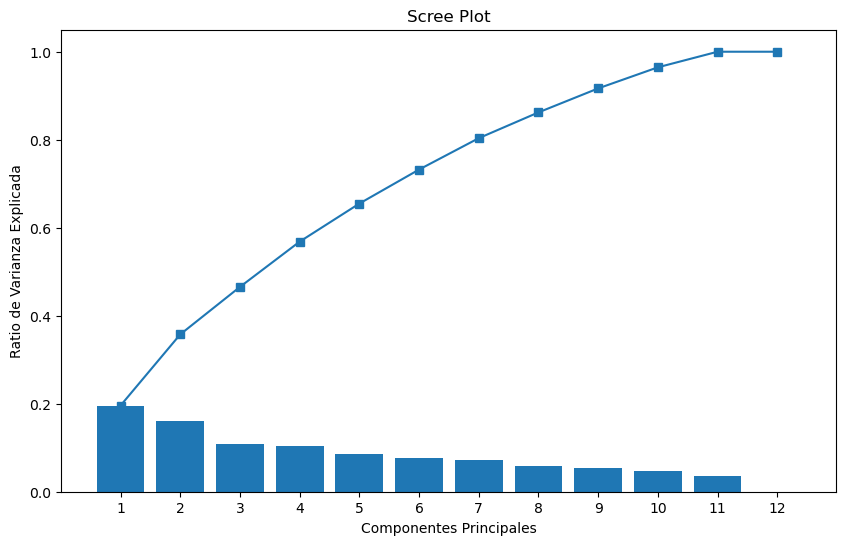

In [91]:
# Observar graficamente el numero de componentes que se necesita para explicar el 80% de la variabilidad de datos
plt.figure(figsize=(10, 6))
plt.bar(range(1, X_pca.shape[1] + 1), pca.explained_variance_ratio_)
plt.plot(range(1, X_pca.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_), marker="s")
plt.xticks(range(1, X_pca.shape[1] + 1))
plt.title("Scree Plot")
plt.xlabel("Componentes Principales")
plt.ylabel("Ratio de Varianza Explicada")
plt.show()

## (b) Realice la predicci´on para los partidos fuera de muestra (en la tabla).

In [92]:
# Se aplica PCR con 7 componentes (explican mas del 80% de la variabilidad de los datos)
pcr = LinearRegression()
pcr.fit(X_pca[:, :7], y)



LinearRegression()

In [37]:
# Create a new dataframe containing PCAs, and HomeTeam and AwayTeam variables
df.reset_index(inplace=True,drop=True)
X_pca7_df = pd.DataFrame(X_pca[:,:7], 
                         columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7'])
X_pca7_df['HomeTeam'] = df['HomeTeam']
X_pca7_df['AwayTeam'] = df['AwayTeam']

In [93]:
def predict_pca(dataframe,hometeam,awayteam, model):
  dataframe = dataframe[(dataframe['HomeTeam'] == hometeam) | (dataframe['AwayTeam'] == awayteam)]
  dataframe = dataframe.drop(['HomeTeam','AwayTeam'], axis = 1).reset_index(drop=True)
  dataframe = dataframe.mean(axis = 0)
  dataframe = dataframe.values.reshape(1, -1)
  y_pred = model.predict(dataframe)
  return y_pred

# y_pred = model.predict(dataframe)

In [39]:
print("Home" if predict_pca(X_pca7_df,'Brighton','Everton',pcr) > 0.5 else "Away")
print("Home" if predict_pca(X_pca7_df,'Nottingham Forest','Southampton',pcr) > 0.5 else "Away")
# print("Home" if predict_pca(X_pca7_df,'Liverpool','Fulham',pcr) > 0.5 else "Away")
# print("Home" if predict_pca(X_pca7_df,'Man City','West Ham',pcr) > 0.5 else "Away")
# print("Home" if predict_pca(X_pca7_df,'Brighton','Man United',pcr) > 0.5 else "Away")

Home
Home


In [40]:
# data = {'Equipo Local': ['Leicester City', 'Arsenal', 'Liverpool', 'Man City', 'Brighton'],
#         'Equipo Visitante': ['Everton', 'Chelsea', 'Fulham', 'West Ham', 'Man United'],
#         'Fecha': ['1.5.23', '2.5.23', '3.5.23', '3.5.23', '4.5.23'],
#         'Hora UK': ['14:00', '14:00', '14:00', '14:00', '14:00']}

# predicciones2 = pd.DataFrame(data)
data = {'Equipo Local': ['Newcastle', 'West Ham' ],
        'Equipo Visitante': ['Arsenal', 'Man United'],
        'Fecha': ['7.5.23', '7.5.23'],
        'Hora UK': ['10:30', '14:00']}
predicciones2 = pd.DataFrame(data)


In [41]:
# predicciones2["Predicción"] = ["Home","Home","Home","Home","Away"]
# predicciones2
predicciones2["Predicción"] = ["Home","Home"]
predicciones2

Equipo Local Equipo Visitante   Fecha Hora UK Predicción
0    Newcastle          Arsenal  7.5.23   10:30       Home
1     West Ham       Man United  7.5.23   14:00       Home